In [1]:
import os
import pickle

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import tqdm
from torch.nn import functional as fnn
from torch.utils import data
from torchvision import transforms

from hack_utils import ScaleMinSideToSize, CropCenter, TransformByKeys
from hack_utils import ThousandLandmarksDataset
from hack_utils import restore_landmarks_batch, create_submission
from hack_utils import stqdm

import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
DATA_DIR = '../data/'
LOCAL_DATA_DIR = '/work/local_data/made_cv/contest1'

In [3]:
GPUs = [0, 1, 2]

In [76]:
NUM_PTS = 971
CROP_SIZE = 128
NUM_WORKERS = 24
BATCH_SIZE = 384

In [5]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [77]:
SIGMA = 12

def make_gaussian_kernel(x0, y0, sigma=SIGMA, height=CROP_SIZE, width=CROP_SIZE):
#     x = np.arange(0, width, 1, np.float16)
#     y = np.arange(0, height, 1, np.float16)[:, np.newaxis]
#     return np.exp(-((x-x0)**2 + (y-y0)**2) / (2*sigma**2))
    return np.empty((height, width), dtype=np.float16)


def make_heatmaps(landmarks, sigma=SIGMA, height=CROP_SIZE, width=CROP_SIZE):
    landmarks = landmarks.reshape(-1, 2)
    heatmap = np.empty((height, width, landmarks.shape[0]), dtype=np.float16)
#     for i in range(landmarks.shape[0]):
#         heatmap[:,:,i] = make_gaussian_kernel(landmarks[i][0],
#                                             landmarks[i][1],
#                                             sigma,
#                                             height, width)
    return heatmap





# def make_gaussian_kernel(x0, y0, sigma=SIGMA, height=CROP_SIZE, width=CROP_SIZE):
# #     x = np.arange(0, width, 1, np.float16)
# #     y = np.arange(0, height, 1, np.float16)[:, np.newaxis]
# #     return np.exp(-((x-x0)**2 + (y-y0)**2) / (2*sigma**2))
#     return torch.empty((height, width), dtype=torch.float16)


# def make_heatmaps(landmarks, sigma=SIGMA, height=CROP_SIZE, width=CROP_SIZE):
#     landmarks = landmarks.reshape(-1, 2)
#     heatmap = torch.empty((height, width, landmarks.shape[0]), dtype=torch.float16)
#     for i in range(landmarks.shape[0]):
#         heatmap[:,:,i] = make_gaussian_kernel(landmarks[i,0],
#                                             landmarks[i,1],
#                                             sigma,
#                                             height, width)
#     return heatmap

In [78]:
class AddMasks(object):
    def __init__(self, sigma=SIGMA, height=CROP_SIZE, width=CROP_SIZE):
        self.sigma = sigma
        self.height = height
        self.width = width

    def __call__(self, sample):
        if 'landmarks' not in sample:
            raise NotImplementedError
        masks = make_heatmaps(sample['landmarks'], sigma=self.sigma, height=self.height, width=self.width)
        sample['masks'] = torch.as_tensor(masks, dtype=torch.float16, device=torch.device('cpu'))
        return sample

In [79]:
train_transforms = transforms.Compose([
    ScaleMinSideToSize((CROP_SIZE, CROP_SIZE)),
    CropCenter(CROP_SIZE),
    AddMasks(),
#     TransformByKeys(transforms.ToPILImage(), ("image",)),
#     TransformByKeys(transforms.ToTensor(), ("image",)),
#     TransformByKeys(transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]), ("image",)),
])

In [80]:
# train_dataset = ThousandLandmarksDataset(os.path.join(LOCAL_DATA_DIR, 'train'), train_transforms, split="train")
# train_dataloader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=False,
#                                    shuffle=False, drop_last=False)

In [81]:
val_dataset = ThousandLandmarksDataset(os.path.join(LOCAL_DATA_DIR, 'train'), train_transforms, split="val")
val_dataloader = data.DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=False,
                                   shuffle=False, drop_last=False)

Total lines (without header): 393930
Loading val dataset (78786 lines)


In [82]:
%%time
for batch in val_dataloader:
    break

RuntimeError: DataLoader worker (pid(s) 31054) exited unexpectedly

In [11]:
MASKS_DIR = os.path.join(LOCAL_DATA_DIR, 'train/masks/')
print(MASKS_DIR)
os.makedirs(MASKS_DIR, exist_ok=True)

/work/local_data/made_cv/contest1/train/masks/


In [12]:
def get_mask_path(img_path):
    fname = os.path.basename(train_dataset.image_names[0])
    fname = os.path.splitext(fname)[0]
    return os.path.join(MASKS_DIR, f'{fname}.pkl')

In [13]:
get_mask_path(train_dataset.image_names[0])

'/work/local_data/made_cv/contest1/train/masks/07c5e48d938e8d82c0f10973d66183f3.pkl'

In [14]:
def make_mask_dataset(dataloader, mask_size=CROP_SIZE, sigma=SIGMA):
    dataset = {'masks': [], 'file_paths': []}
    for batch in stqdm(dataloader, total=len(dataloader), desc='Batch'):
        for sample in batch:
            mask_path = get_mask_path(sample['image_name'])
            mask = sample['mask']
            dataset['mask'].append(mask)
            dataset['mask_path'].append(mask_path)
    return dataset

In [15]:
val_mask_dataset = make_mask_dataset(val_dataloader)

KeyboardInterrupt: 

In [16]:
train_mask_dataset = make_mask_dataset(train_dataloader)

KeyboardInterrupt: 

In [304]:
idx = 23142

In [305]:
sample = train_dataset[idx]

In [313]:
sample_heatmaps = make_heatmaps(sample['landmarks'], sigma=12)
sample_heatmaps.shape

(128, 128, 971)

In [314]:
lm_idx = 43

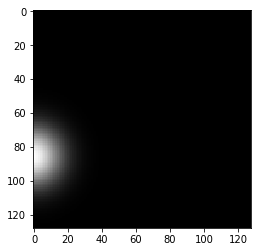

In [315]:
plt.imshow(sample_heatmaps[:,:,lm_idx], cmap='gray', vmin=0, vmax=1)

In [156]:
sample['landmarks'].reshape(-1, 2)[lm_idx]

tensor([-1.1302, 85.3532])

In [157]:
np.unravel_index(sample_heatmaps[:,:,lm_idx].argmax(), sample_heatmaps[:,:,lm_idx].shape)

(85, 0)

In [159]:
top5_indices = np.argpartition(sample_heatmaps[:,:,lm_idx], -4, axis=None)
ind[np.argsort(a[ind])]

In [161]:
top5_indices.shape

(16384,)

In [227]:
def get_top_k_indices(arr, k=5):
    top_indices = np.argpartition(arr, -k, axis=None)[-k:]
    sorted_top_indices = top_indices[np.argsort(arr[top_indices], axis=None)][::-1]
    return sorted_top_indices

def get_top_k_indices2d(arr, k=5):
    ravel_top_indices = get_top_k_indices(arr.ravel(), k)
    y_top_indices, x_top_indices = np.unravel_index(ravel_top_indices, arr.shape)
    return ravel_top_indices, x_top_indices, y_top_indices, arr.ravel()[ravel_top_indices]

In [258]:
_, x_, y_, vals_ = get_top_k_indices2d(sample_heatmaps[:,:,lm_idx], 5)

In [259]:
weights = vals_ / vals_.sum()

In [261]:
np.sum(x_ * weights), np.sum(y_ * weights)

(0.19882725179195404, 85.39956702291965)

In [330]:
train_mask_dataset = make_mask_dataset(train_dataset)

KeyboardInterrupt: 